## Convolutional Neural Network Model for Audio Classification

<br/>
by Eduardo Garcia Rajo @ 2019<br/>
<br/>
This notebook if part of the project [Urban sounds classification with Covnolutional Neural Networks](https://github.com/GorillaBus/urban-audio-classifier) on my Github.<br/>
<br/>
Licensed under the GNU LESSER GENERAL PUBLIC LICENSE Version 3, 29 June 2007<br/>
<br/>

## Appendix I
### Exploring average peak amplitude

We would like to see how normalizing this aspect of the audio signals in our dataset may affect the training process. For this we first need to convert all the audio files in our dataset to a common format (22.050khz, 16bit), for what we are using FFMPEG as a reliable tool for the job.<br/>
<br/>
Once the dataset data has been converted we'll use PyDub to match the average peak amplitude to the value of -20db.<br/>
<br/>
After all this process is done we'll be able to run the basic CNN model on features extracted from the new normalized audio and see if we ca get at least a small increase in accuracy.<br/>
<br/>
<br/>

In [1]:
import pydub
from pydub import AudioSegment
import sys
import os
import subprocess
import IPython
from IPython.core.display import HTML
import time
import math
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.pyplot as plot
from scipy.io import wavfile

In [2]:
# Define general variables

us8k_path = os.path.abspath('./UrbanSound8K')
audio_path = os.path.join(us8k_path, 'audio')
metadata_path = os.path.join(us8k_path, 'metadata/UrbanSound8K.csv')
output_path = os.path.abspath('./data/dbfs_normalized')
temp_audio_path = os.path.abspath('./data/tmp')

### Helper functions

In [3]:
# Resamples a file to 22.050khz, 16 bit
def resample_file(src_file, dst_file, sr):
    subprocess.call('ffmpeg -i {} -ac 1 -ar {} -acodec pcm_s16le -loglevel error -y {}'.format(
        src_file, sr, dst_file), shell=True)
    
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

def plot_spectogram(file_path, title='Linear-frequency power spectrogram', size=(9,9)):
    y, sr = librosa.load(file_a)
    plt.figure(figsize=(12, 8))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)

def plot_wave(file_path, title="Waveform", size=(9,9)):
    y, sr = librosa.load(file_path)
    plt.figure(figsize=size)
    plt.subplot(3, 1, 1)
    librosa.display.waveplot(y, sr=sr)
    plt.title(title)

In [4]:
# Load the metadata from the generated CSV
metadata = pd.read_csv(metadata_path)

### Audio conversion and Average Peak Normalization
Convert all audio files into 22.050khz, 16bit format using ffmpeg (should be installed in your system first), and normalize the Average Peak Amplitude to -20db in all audio files.

In [7]:
sample_rate = 22050
normal_dBFS = -20
total = len(metadata)
counter = 0

print(">>> Normalizing dataset sample rate to {} Khz and average amplitude to {} dBFS".format(sample_rate, normal_dBFS))

# Create temp directory (for resampling) if it does not exist
if not os.path.exists(temp_audio_path):
    print(">>> Creating temp directory: {}".format(temp_audio_path))
    os.makedirs(temp_audio_path)

# Create output directory if it does not exist
if not os.path.exists(output_path):
    print(">>> Creating output directory: {}".format(output_path))
    os.makedirs(output_path)

for idx, row in metadata.iterrows():
    fold = "fold" + str(row['fold'])
    file_name = row['slice_file_name']
    file_path = os.path.join(audio_path, fold, file_name)
    file_temp_path = os.path.join(temp_audio_path, file_name)
    fold_output_path = os.path.join(output_path, fold)
    file_output_path = os.path.join(fold_output_path, file_name)
    
    # Create output directory if it does not exist
    if not os.path.exists(fold_output_path):
        print(">>> Creating dir {}".format(fold_output_path))
        os.makedirs(fold_output_path)
    
    # Resample the file to 22050 with ffmpeg using codec "pcm_s16le"
    resample_file(file_path, file_temp_path, sample_rate)

    # Load file and get average amplitude in dBFS, using ffmpeg via PyDub
    sound = AudioSegment.from_file(file_temp_path, "wav")

    # Normalize the average amplitude and save the new file
    normalized = match_target_amplitude(sound, normal_dBFS)
    normalized.export(file_output_path, format="wav")
    
    # Remove temp file
    os.remove(file_temp_path)
    
    
    # Display progress
    if (counter % 1000 == 0):
        print(">>> completed {} of {}".format(counter, total))
    
    counter += 1
    
print(">>> completed {} of {}".format(counter, total))

>>> Normalizing dataset sample rate to 22050 Khz and average amplitude to -20 dBFS
>>> Creating temp directory: /mnt/disks/disk-1/projects/urban-audio-classifier/data/tmp
>>> Creating output directory: /mnt/disks/disk-1/projects/urban-audio-classifier/data/dbfs_normalized
>>> Creating dir /mnt/disks/disk-1/projects/urban-audio-classifier/data/dbfs_normalized/fold5
>>> completed 0 of 8732
>>> Creating dir /mnt/disks/disk-1/projects/urban-audio-classifier/data/dbfs_normalized/fold10
>>> Creating dir /mnt/disks/disk-1/projects/urban-audio-classifier/data/dbfs_normalized/fold2
>>> Creating dir /mnt/disks/disk-1/projects/urban-audio-classifier/data/dbfs_normalized/fold6
>>> Creating dir /mnt/disks/disk-1/projects/urban-audio-classifier/data/dbfs_normalized/fold1
>>> Creating dir /mnt/disks/disk-1/projects/urban-audio-classifier/data/dbfs_normalized/fold9
>>> Creating dir /mnt/disks/disk-1/projects/urban-audio-classifier/data/dbfs_normalized/fold7
>>> Creating dir /mnt/disks/disk-1/projects/

### Average Peak Amplitude comparison
Get three random samples from those where the average amplitude was mostly different from the desired normal value and display waveforms and scales.

In [9]:
range_start = normal_dBFS + 3
range_end = normal_dBFS + -3
segment = results[(results['orig_dbfs'] > range_start) | (results['orig_dbfs'] < range_end)].sample(3)

colors = ['blue', 'gray', 'maroon']
color_idx = 0

segment

,filename,original,resampled,normalized,orig_dbfs,norm_dbfs
6,74507-0-0-22.wav,/mnt/disks/disk-1/projects/urban-audio-classif...,/mnt/disks/disk-1/projects/urban-audio-classif...,/mnt/disks/disk-1/projects/urban-audio-classif...,-23.211470,-19.999470
2,58857-2-0-10.wav,/mnt/disks/disk-1/projects/urban-audio-classif...,/mnt/disks/disk-1/projects/urban-audio-classif...,/mnt/disks/disk-1/projects/urban-audio-classif...,-36.594164,-19.994170
8,135526-6-3-0.wav,/mnt/disks/disk-1/projects/urban-audio-classif...,/mnt/disks/disk-1/projects/urban-audio-classif...,/mnt/disks/disk-1/projects/urban-audio-classif...,-12.930235,-20.002121


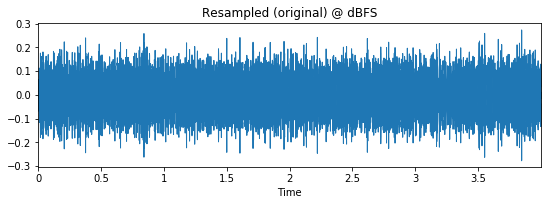

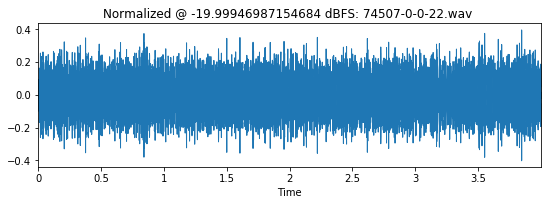

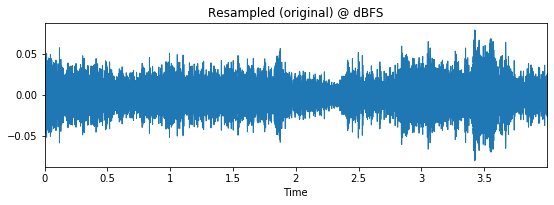

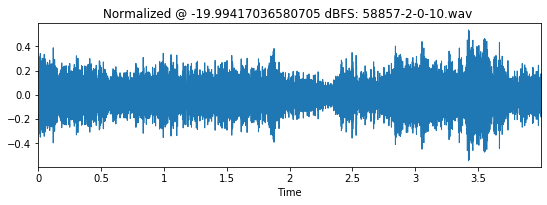

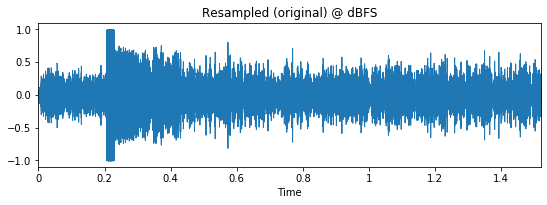

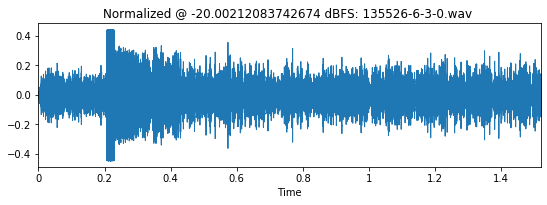

In [10]:
# Iterate the segment and plot audio waves
for idx, row in segment.iterrows():

    # load origina and normalized
    name = results['filename'][idx]
    file_resampled = results['resampled'][idx]
    file_normalized = results['normalized'][idx]
    orig_dbfs = results['orig_dbfs'][idx]
    norm_dbfs = results['norm_dbfs'][idx]
    
    # Original
    plot_wave(file_resampled, "Resampled (original) @ dBFS".format(orig_dbfs))
    
    # Normalized
    plot_wave(file_normalized, "Normalized @ {} dBFS: {} ".format(norm_dbfs, name))

The three examples show the Original (resampled) vs the Normalized (avg peak amp), displaying the same scale for all the normalized data.<br/>
<br/>
Normalized audio data has been saved in the file system for later use.<br/>
<br/>